### Import modules

In [1]:
import networkx as nx

from agents import GUCB_agent, local_ts_agent, local_ucb_agent,UCRL2_agent,QL_agent,QL_UCB_Hoeffding
from utils import return_graph,draw_graph
from core import train_agent
from planning import offline_SP_planning

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

SEED = 181731

In [2]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': r'QL-$\epsilon$ greedy',\
              'Our Algorithm':'Our Algorithm','UCRL2':'UCRL2','QL_UCB_H':'QL-UCB-H'}
    styles = {'greedy': 'dashed', 'thompson': 'dashed', 'UCB': 'dashed','Q_learning': 'dotted',\
              'Our Algorithm':'solid','UCRL2':'solid','QL_UCB_H':'dotted'}
    colors = {'greedy': 'b', 'thompson': 'r', 'UCB': 'g','Q_learning': 'r',\
              'Our Algorithm':'k','UCRL2':'g','QL_UCB_H':'b'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
                    axes[1,j%3].set_title(titles[j])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

### Define parameters

In [3]:
n_samples = 100

init_node = 0

# Non-FC graphs.

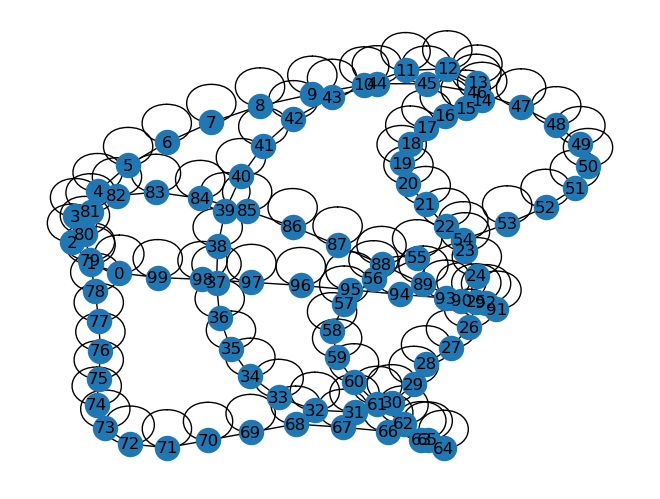

Run time for thompson: 6.270258903503418
Run time for UCB: 3.351447105407715
Run time for UCRL2: 15.114820957183838
Run time for Our Algorithm: 5.185251712799072
Run time for Q_learning: 7.8519086837768555
Run time for QL_UCB_H: 23.671298027038574


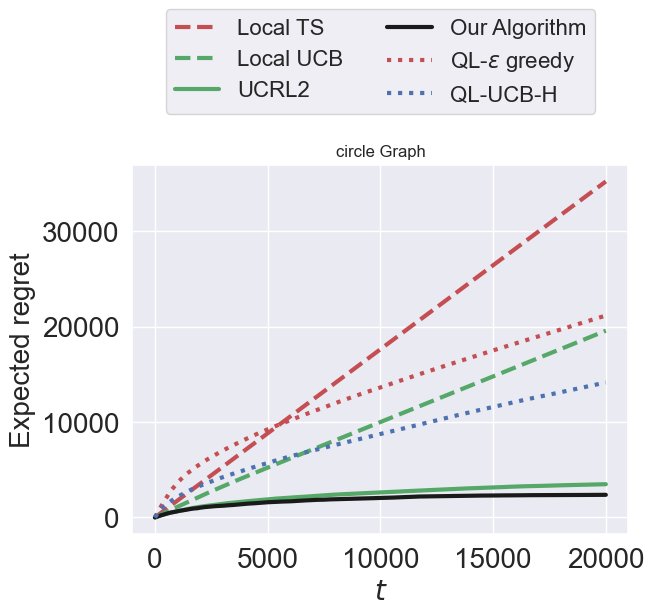

Total run time: 61.82155704498291


In [4]:
# graph_types = ['line','circle','tree','grid','star']
graph_types = ['circle']

T = 20000
n_nodes = 100

for graph in graph_types:
    np.random.seed(SEED)
    G = return_graph(graph, n_nodes)
    draw_graph(G)

    np.random.seed(SEED)
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    agents = {
    'thompson':partial(local_ts_agent,var=1.0,mu_0=0.0,var_0=1.0),
         'UCB':local_ucb_agent,
         'UCRL2':UCRL2_agent,
         'Our Algorithm':GUCB_agent,
        'Q_learning':QL_agent,
        'QL_UCB_H':QL_UCB_Hoeffding
}

    t0 = time()
    line_regrets = {}
    for name,agent in agents.items():
        t = time()
        line_regrets[name] = train_agent(n_samples,T,G,means, init_node,agent,parallelized=True)
        print('Run time for {}:'.format(name),time()-t)


    with open('Data/{}_large.pkl'.format(graph), 'wb') as file:
        pkl.dump(line_regrets,file)

    plt.figure(dpi=100)

    plotRegrets([line_regrets], titles=['{} Graph'.format(graph)])
    print('Total run time:', time()-t0)

# Fully-connected graph

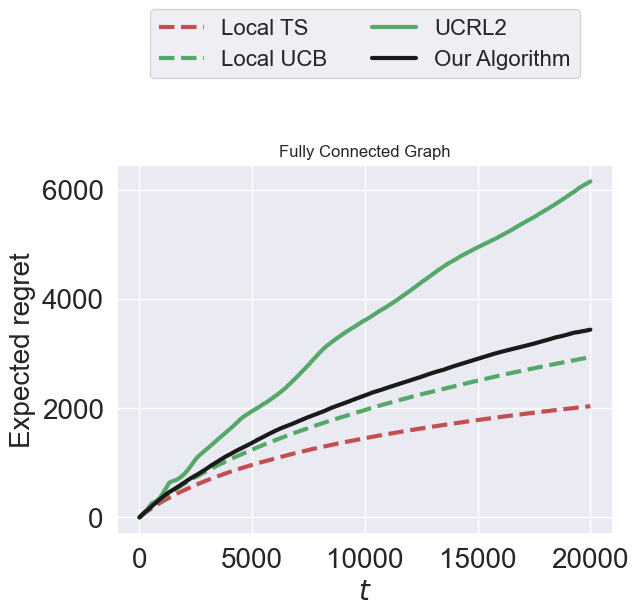

Total run time: 417.0803780555725


In [10]:
T = 20000

np.random.seed(SEED)
n_nodes = 100
G = return_graph('fully_connected', n_nodes)
draw_graph(G)

np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=1.5,size=(n_samples,n_nodes))

t0=time()
agents = {
    'thompson':local_ts_agent,
         'UCB':local_ucb_agent,
         'UCRL2':UCRL2_agent,
         'Our Algorithm':GUCB_agent}

line_regrets = {}
for name,agent in agents.items():
    t = time()
    line_regrets[name] = train_agent(n_samples,T,G,means, init_node,agent,parallelized=True)
    print('Run time for {}:'.format(name),time()-t)
    
with open('Data/{}_large.pkl'.format('fully_connected'), 'wb') as file:
    pkl.dump(line_regrets,file)
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Fully Connected Graph'])
print('Total run time:', time()-t0)